In [3]:
import os
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib

In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# ============================================================
# 1. CONFIG
# ============================================================
ACCEPTED_PATH = "accepted_2007_to_2018Q4.csv"
REJECTED_PATH = "rejected_2007_to_2018Q4.csv"

TARGET_COL = "default"
SOURCE_COL = "application_status"

NUMERIC_FEATURES = [
    "loan_amnt",
    "int_rate",
    "annual_inc",
    "dti",
    "emp_length_num",
    "fico_range_low"
]

CATEGORICAL_FEATURES = [
    "purpose",
    "grade",
    "home_ownership",
    "addr_state"
]

LOSS_COL = "loss_rate"
EAD_COL = "loan_amnt"

# Memory / behavior flags
USE_SMOTE = False
SMOTE_SAMPLE_SIZE = 200_000
HIGH_CARD_THRESHOLD = 30
MODEL_OUTPUT_PATH = "credit_pd_model.joblib"

In [5]:
# ============================================================
# 2. DATA LOADING & PREPARATION
# ============================================================
def load_and_prepare_data():
    """Load and prepare both accepted and rejected datasets."""
    try:
        accepted = pd.read_csv(ACCEPTED_PATH, low_memory=False)
        rejected = pd.read_csv(REJECTED_PATH, low_memory=False)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Data file not found: {e}")

    accepted[SOURCE_COL] = "accepted"
    rejected[SOURCE_COL] = "rejected"

    if "loan_status" not in accepted.columns:
        raise ValueError("Column 'loan_status' not found in accepted data.")

    good_statuses = ["Fully Paid"]
    bad_statuses = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "Late (31-120 days)"]

    def map_default(status):
        if status in good_statuses:
            return 0
        if status in bad_statuses:
            return 1
        return np.nan

    accepted[TARGET_COL] = accepted["loan_status"].apply(map_default)
    accepted = accepted.dropna(subset=[TARGET_COL])
    accepted[TARGET_COL] = accepted[TARGET_COL].astype(int)

    # Process employment length
    if "emp_length" in accepted.columns:
        accepted["emp_length_num"] = process_emp_length(accepted["emp_length"])
    if "emp_length" in rejected.columns:
        rejected["emp_length_num"] = process_emp_length(rejected["emp_length"])

    return accepted, rejected

In [6]:
def process_emp_length(emp_length_series):
    """Convert employment length strings to numeric values."""
    return (
        emp_length_series
        .fillna("0")
        .replace({"10+ years": "10", "< 1 year": "0", "n/a": "0"})
        .str.extract(r"(\d+)", expand=False)
        .fillna("0")
        .astype(float)
    )

In [7]:
# ============================================================
# 3. EDA & UTILITIES
# ============================================================
def basic_eda(df: pd.DataFrame, target: str, name: str):
    """Print basic exploratory data analysis."""
    print(f"\n===== BASIC INFO: {name} =====")
    print(df.info())
    print("\n===== HEAD =====")
    print(df.head())
    if target in df.columns:
        print("\n===== TARGET VALUE COUNTS =====")
        print(df[target].value_counts(dropna=False))
        default_rate = df[target].mean()
        print(f"\nOverall default rate ({name}): {default_rate:.2%}")

def plot_default_rate_by_category(df: pd.DataFrame, target: str, category: str):
    """Plot default rates by category."""
    if category not in df.columns:
        return
    
    try:
        rates = df.groupby(category)[target].mean().sort_values(ascending=False)
        plt.figure(figsize=(8, 4))
        sns.barplot(x=rates.index, y=rates.values)
        plt.title(f"Default rate by {category}")
        plt.ylabel("Default rate")
        plt.xlabel(category)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot {category}: {e}")

In [8]:
# ============================================================
# 4. PREPROCESSOR BUILDING
# ============================================================
def build_preprocessor_from_data(df, numeric_features, categorical_features, high_card_threshold=HIGH_CARD_THRESHOLD):
    """
    Build a ColumnTransformer using actual df cardinality.
    Returns: preprocessor, numeric_used, low_card_cats, high_card_cats
    """
    numeric_used = [c for c in numeric_features if c in df.columns]
    categorical_used = [c for c in categorical_features if c in df.columns]

    low_card = []
    high_card = []
    
    for c in categorical_used:
        nunique = df[c].nunique(dropna=True)
        if nunique <= high_card_threshold:
            low_card.append(c)
        else:
            high_card.append(c)

    # Numeric pipeline
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Low-cardinality: one-hot encoding
    onehot_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    # High-cardinality: ordinal encoding
    ordinal_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])

    transformers = [("num", numeric_transformer, numeric_used)]
    if low_card:
        transformers.append(("cat_onehot", onehot_transformer, low_card))
    if high_card:
        transformers.append(("cat_ord", ordinal_transformer, high_card))

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")
    return preprocessor, numeric_used, low_card, high_card

In [9]:
# ============================================================
# 5. MODEL TRAINING & EVALUATION
# ============================================================
def train_pd_model(X_train, y_train, preprocessor, model_type="log_reg", use_smote=USE_SMOTE):
    """Train a PD model with optional SMOTE."""
    if model_type == "log_reg":
        model = LogisticRegression(max_iter=1000, class_weight="balanced" if not use_smote else None, random_state=42)
    elif model_type == "rf":
        model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced" if not use_smote else None, n_jobs=-1)
    else:
        raise ValueError("model_type must be 'log_reg' or 'rf'")

    if use_smote:
        clf = ImbPipeline(steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=42, k_neighbors=5)),
            ("model", model)
        ])
    else:
        clf = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])

    clf.fit(X_train, y_train)
    return clf

def evaluate_pd_model(clf, X_test, y_test, threshold=0.5, name="Model"):
    """Evaluate model performance."""
    try:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
    except Exception as e:
        print(f"Error getting probabilities: {e}")
        return None, None

    y_pred = (y_pred_proba >= threshold).astype(int)

    print(f"\n===== {name} EVALUATION =====")
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC AUC: {auc_score:.4f}")
    except Exception as ex:
        print(f"ROC AUC could not be computed: {ex}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return y_pred_proba, y_pred

def analyze_pd_cutoffs(test_df, target, pd_col="pd_pred", thresholds=None):
    """Analyze performance at different PD thresholds."""
    if thresholds is None:
        thresholds = [0.05, 0.1, 0.2, 0.3]

    print("\n===== PD CUT-OFF ANALYSIS =====")
    for thr in thresholds:
        approved = test_df[test_df[pd_col] <= thr]
        declined = test_df[test_df[pd_col] > thr]
        approval_rate = len(approved) / len(test_df) if len(test_df) > 0 else 0
        default_rate_approved = approved[target].mean() if len(approved) > 0 else 0

        print(f"\nPD Threshold: {thr:.2f}")
        print(f"  Approval rate: {approval_rate:.2%}")
        print(f"  Default rate among approved: {default_rate_approved:.2%}")
        print(f"  Count - Approved: {len(approved)}, Declined: {len(declined)}")

def compute_portfolio_expected_loss(df, features, clf, loss_col, ead_col, target):
    """Compute portfolio expected loss metrics."""
    if loss_col not in df.columns or ead_col not in df.columns:
        print("\nLoss or EAD column missing; skipping expected loss computation.")
        return None

    df = df.copy()
    
    try:
        df["pd_pred"] = clf.predict_proba(df[features])[:, 1]
    except Exception as ex:
        print(f"Could not compute PDs for EL: {ex}")
        return None

    df["LGD"] = df[loss_col].clip(lower=0, upper=1)
    df["EAD"] = df[ead_col].clip(lower=0)
    df["expected_loss"] = df["pd_pred"] * df["LGD"] * df["EAD"]

    total_el = df["expected_loss"].sum()
    avg_el = df["expected_loss"].mean()

    print("\n===== PORTFOLIO EXPECTED LOSS =====")
    print(f"Total portfolio expected loss: {total_el:,.2f}")
    print(f"Average expected loss per loan: {avg_el:,.2f}")

    if "grade" in df.columns:
        print("\nExpected loss by grade:")
        el_by_grade = df.groupby("grade")["expected_loss"].sum().sort_values(ascending=False)
        print(el_by_grade)

    return df

def score_rejected_applications(rejected_df, features, clf):
    """Score rejected applications using trained model."""
    common_cols = [c for c in features if c in rejected_df.columns]
    if not common_cols:
        print("\nNo overlapping features between accepted and rejected for scoring.")
        return None

    rejected = rejected_df.copy()
    
    try:
        rejected["pd_pred"] = clf.predict_proba(rejected[common_cols])[:, 1]
    except Exception as ex:
        print(f"Could not score rejected applications: {ex}")
        return None

    print("\n===== REJECTED APPLICATIONS – PD SUMMARY =====")
    print(rejected["pd_pred"].describe())
    print(f"\nHigh-risk rejected (pd_pred > 0.3): {(rejected['pd_pred'] > 0.3).mean():.2%}")
    print(f"Very low-risk rejected (pd_pred < 0.05): {(rejected['pd_pred'] < 0.05).mean():.2%}")
    
    return rejected

Loading data...

===== BASIC INFO: ACCEPTED =====
<class 'pandas.core.frame.DataFrame'>
Index: 1367578 entries, 0 to 2260697
Columns: 154 entries, id to emp_length_num
dtypes: float64(114), int64(1), object(39)
memory usage: 1.6+ GB
None

===== HEAD =====
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   
5  68426831        NaN    11950.0      11950.0          11950.0   36 months   

   int_rate  installment grade sub_grade  ... debt_settlement_flag  \
0     13.99       123.03     C        C4  ...                    N   
1     11.99       820.28     C        C1  ...                    N   
2     10.78       432.66     B        B4  ...              

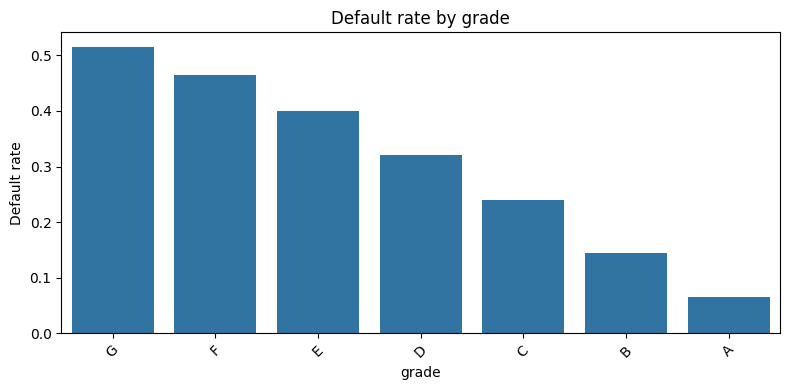

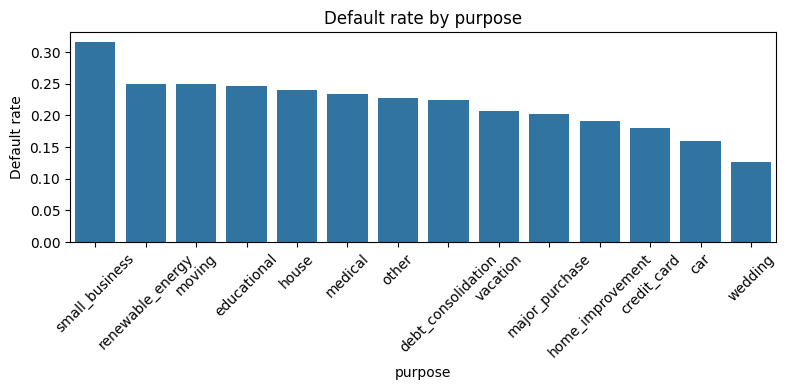

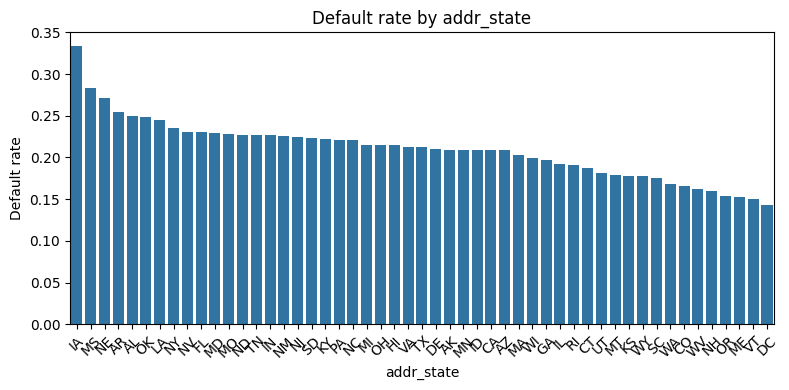


Building preprocessor (automatic cardinality split)...
  Numeric features: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'emp_length_num', 'fico_range_low']
  OneHot (low-cardinality): ['purpose', 'grade', 'home_ownership']
  Ordinal (high-cardinality): ['addr_state']
  Preprocessor test successful. Shape: (100, 22)

Training Logistic Regression (class_weight='balanced')...

===== Logistic Regression EVALUATION =====
ROC AUC: 0.6981

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72    215351
           1       0.32      0.68      0.43     58165

    accuracy                           0.62    273516
   macro avg       0.60      0.64      0.58    273516
weighted avg       0.76      0.62      0.66    273516


Confusion Matrix:
[[130859  84492]
 [ 18660  39505]]

Training Random Forest (class_weight='balanced')...

===== Random Forest EVALUATION =====
ROC AUC: 0.6916

Classification Report:
              precision  

In [10]:
# ============================================================
# 6. MAIN PIPELINE
# ============================================================
def main():
    """Main execution pipeline."""
    warnings.filterwarnings("ignore")
    
    print("Loading data...")
    try:
        accepted_df, rejected_df = load_and_prepare_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    basic_eda(accepted_df, TARGET_COL, "ACCEPTED")
    
    for cat in ["grade", "purpose", "addr_state"]:
        plot_default_rate_by_category(accepted_df, TARGET_COL, cat)

    # Select features
    features = [f for f in NUMERIC_FEATURES + CATEGORICAL_FEATURES if f in accepted_df.columns]
    missing = set(NUMERIC_FEATURES + CATEGORICAL_FEATURES) - set(features)
    if missing:
        print(f"\nWARNING: Features not found in data: {missing}")

    X = accepted_df[features]
    y = accepted_df[TARGET_COL]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Build and test preprocessor
    print("\nBuilding preprocessor (automatic cardinality split)...")
    full_data = pd.concat([X_train, X_test], ignore_index=True)
    preprocessor, numeric_used, low_card_cats, high_card_cats = build_preprocessor_from_data(
        full_data, NUMERIC_FEATURES, CATEGORICAL_FEATURES, high_card_threshold=HIGH_CARD_THRESHOLD
    )

    print(f"  Numeric features: {numeric_used}")
    print(f"  OneHot (low-cardinality): {low_card_cats}")
    print(f"  Ordinal (high-cardinality): {high_card_cats}")

    # Sanity check
    try:
        X_small = X_train.head(100)
        preprocessor.fit(X_small, y_train.head(100))
        transformed = preprocessor.transform(X_small)
        print(f"  Preprocessor test successful. Shape: {transformed.shape}")
    except Exception as ex:
        print(f"  ERROR: Preprocessor failed: {ex}")
        return

    # Train Logistic Regression
    print("\nTraining Logistic Regression (class_weight='balanced')...")
    try:
        log_reg_clf = train_pd_model(X_train, y_train, preprocessor, model_type="log_reg", use_smote=False)
        y_pred_proba_lr, _ = evaluate_pd_model(log_reg_clf, X_test, y_test, threshold=0.5, name="Logistic Regression")
    except Exception as e:
        print(f"Error training Logistic Regression: {e}")
        return

    # Train Random Forest
    print("\nTraining Random Forest (class_weight='balanced')...")
    try:
        rf_clf = train_pd_model(X_train, y_train, preprocessor, model_type="rf", use_smote=False)
        evaluate_pd_model(rf_clf, X_test, y_test, threshold=0.5, name="Random Forest")
    except Exception as e:
        print(f"Error training Random Forest: {e}")

    # Cut-off analysis
    if y_pred_proba_lr is not None:
        test_results = X_test.copy()
        test_results[TARGET_COL] = y_test.values
        test_results["pd_pred"] = y_pred_proba_lr
        analyze_pd_cutoffs(test_results, TARGET_COL, pd_col="pd_pred")

        # Expected loss analysis
        compute_portfolio_expected_loss(
            df=accepted_df,
            features=features,
            clf=log_reg_clf,
            loss_col=LOSS_COL,
            ead_col=EAD_COL,
            target=TARGET_COL
        )

    # Score rejected applications
    try:
        score_rejected_applications(rejected_df, features, log_reg_clf)
    except Exception as e:
        print(f"Error scoring rejected applications: {e}")

    # Save model
    try:
        joblib.dump(log_reg_clf, MODEL_OUTPUT_PATH)
        print(f"\nModel saved to: {MODEL_OUTPUT_PATH}")
    except Exception as ex:
        print(f"Could not save model: {ex}")

if __name__ == "__main__":
    main()